In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = json.load(open('../log.json'))

In [3]:
world = [
    d for d in data if "data" in d and "World" in d["data"]
]
debug = [
    d for d in data if "data" in d and "Debug" in d["data"]
]

[{'timestamp': 6.6274e-05}, {'timestamp': 0.000407151}, {'data': {'Debug': {}}, 'timestamp': 0.000494835}, {'timestamp': 0.009521319}, {'data': {'World': {'ball': None, 'current_game_state': {'game_state': {'type': 'Unknown'}, 'us_operating': True}, 'dt': 0.0, 'field_geom': None, 'opp_players': [], 'own_players': [], 'player_model': {'dribbler_angle': 0.9773843811168246, 'max_acceleration': 125000.0, 'max_angular_acceleration': 349.0658503988659, 'max_angular_speed': 25.132741228718345, 'max_speed': 3120.0, 'radius': 90.0}, 't_capture': 0.0, 't_received': 0.0}}, 'timestamp': 0.009577854}, {'timestamp': 0.009585108}, {'data': {'Debug': {'ball.confidence': {'data': 0.9998000264167786, 'type': 'Number'}}}, 'timestamp': 0.00959667}, {'timestamp': 0.025487819}, {'data': {'World': {'ball': None, 'current_game_state': {'game_state': {'type': 'Unknown'}, 'us_operating': True}, 'dt': 0.015930062, 'field_geom': None, 'opp_players': [], 'own_players': [], 'player_model': {'dribbler_angle': 0.9773

In [13]:
player = {
    w["timestamp"]: w["data"]["World"]["own_players"][0] for w in world if len(w["data"]["World"]["own_players"]) > 0
}
player_debug = {
    d["timestamp"]: { k[3:]: v for k, v in d["data"]["Debug"].items() if k.startswith("p0") and len(v) > 0 } for d in debug if len(d["data"]["Debug"]) > 0
}
mtp_mode = {d["timestamp"]: {k: v["data"] for k, v in d["data"]["Debug"].items() if k.startswith("p5")} for d in debug if len(d["data"]["Debug"]) > 0 and "p5.MTPMode" in d["data"]["Debug"]}

shorter = player if len(player) < len(player_debug) else player_debug
longer = player_debug if len(player) < len(player_debug) else player
merged_player = {}
for t, p in shorter.items():
    closest = min(longer.keys(), key=lambda x: abs(x - t))
    closest_mtp = min(mtp_mode.keys(), key=lambda x: abs(x - t))
    merged_player[t] = {**p, **longer[closest], **mtp_mode[closest_mtp]}

In [95]:
def ag_cat(x: list[str] | list[int]):
    cnt = {}
    for s in x:
        if s not in cnt.keys():
            cnt[s] = 0
        cnt[s] += 100.0 / len(x)

    out = ''
    for s in cnt.keys():
        out += f'{s}: {cnt[s]:.0f}%;'
    return out

def ag_float(x: list[float]):
    x.sort()
    l = len(x)
    low, q10, q50, q90, high = x[0], x[int(l * 0.10)], x[int(l * 0.5)], x[int(l * 0.90)], x[-1]
    return f'{low:.2f}/{q10:.2f}/{q50:.2f}/{q90:.2f}/{high:.2f}' 

def ag_list_float(x: list[list[float]]):
    x = np.array(x)
    mn = np.min(x, axis=0)
    mx = np.max(x, axis=0)
    mid = x[len(x) // 2]
    avg = np.mean(x, axis=0)
    np.set_printoptions(precision=2)
    out = f'{mid}| avg {avg} (from min {mn} to max {mx})'
    np.set_printoptions(precision=7)
    return out

In [99]:
def unlog(time_start, time_end):
    if time_end < 0:
        time_end = max(player.keys()) + time_end 
    if time_start < 0:
        time_start = max(player.keys()) + time_start
    
    # collect the data
    agg = []
    for tm, data in player.items():
        if tm < time_start or tm > time_end:
            continue
        agg.append(data)

    for tm, data in player_debug.items():
        if tm < time_start or tm > time_end:
            continue
        agg.append(data)

    # list of dicts -> dict of lists
    cagg = {}
    keys = set()
    for dct in agg:
        for el in list(dct.keys()):
            keys.add(el)
    for k in keys:
        cagg[k] = []
    for el in agg:
        for k in el.keys():
            cagg[k].append(el[k])
    # pretty output according to arbitary rules
    cute_log = {}
    for key, list_of_vals in cagg.items():
        out = list_of_vals
        try:
            if key == 'timestamp':
                out = f"{list_of_vals[0]} - {list_of_vals[-1]}"
            elif list_of_vals[0] is None:
                out = 'bunch of Nones'
            elif type(list_of_vals[0]) == float:
                out = ag_float(list_of_vals)
            elif type(list_of_vals[0]) == int or type(list_of_vals[0]) == str or type(list_of_vals[0]) == bool:
                out = ag_cat(list_of_vals)
            elif type(list_of_vals[0]) == list:
                out = ag_list_float(list_of_vals)
        except Exception as e:
            print(e)

            print("broky :( -> shoot roma in the head")
        cute_log[key] = out
    cute_log['aggregation_duration'] = f'{time_end - time_start:.1f}'
    return cute_log

In [100]:
unlog(2, -1)

{'breakbeam_ball_detected': 'False: 96%;True: 4%;',
 'velocity': '[-1.31  2.7 ]| avg [38.85 -9.65] (from min [ -493.98 -1902.11] to max [ 624.61 1192.57])',
 'angular_speed': '-5.68/-1.05/-0.00/1.52/5.45',
 'pack_voltages': '[12.99  0.79]| avg [10.96  0.2 ] (from min [9.45 0.  ] to max [12.99  0.79])',
 'timestamp': '1721124673.420017 - 1721124689.547122',
 'raw_position': '[  65.53 2222.93]| avg [-134.55 1149.05] (from min [-641.16  -11.02] to max [ 263.12 2224.95])',
 'yaw': '-0.62/-0.07/0.78/1.54/2.96',
 'kicker_temp': 'bunch of Nones',
 'raw_yaw': '-0.72/-0.05/0.78/1.57/3.02',
 'kicker_cap_voltage': '93.80/93.80/94.82/186.59/234.51',
 'id': '2: 100%;',
 'primary_status': 'Ok: 100%;',
 'position': '[  65.98 2222.91]| avg [-134.55 1149.06] (from min [-640.77  -13.43] to max [ 265.25 2224.43])',
 'aggregation_duration': '16.1'}

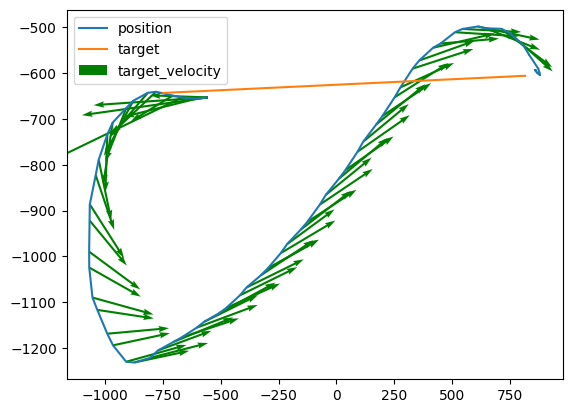

In [85]:
targets = np.array([p["control.target"]["data"]["data"]["center"] for p in merged_player.values() if "control.target" in p])
local_u = np.array([[p["sx"]["data"], p["sy"]["data"]] for p in merged_player.values() if "sx" in p])

orientation = np.array([[np.cos(p["yaw"]), np.sin(p["yaw"])] for p in merged_player.values()])

positions = np.array([p["position"] for p in merged_player.values()])
velocities = np.array([p["velocity"] for p in merged_player.values()])

target_vel_end = np.array([p["target_velocity"]["data"]["data"]["end"] for p in merged_player.values() if "target_velocity" in p])
target_vel_start = np.array([p["target_velocity"]["data"]["data"]["start"] for p in merged_player.values() if "target_velocity" in p])
target_velocities = target_vel_end - target_vel_start

# plt.plot(positions[:, 0], positions[:, 1], label="position")
# animate with slider
fig, ax = plt.subplots()
t_start = 5
t_end = 10

idx1 = next((i for i, p in enumerate(merged_player.keys()) if p > t_start), 0)
idx2 = next((i for i, p in enumerate(merged_player.keys()) if p > t_end), -1)

ax.plot(positions[idx1:idx2, 0], positions[idx1:idx2, 1], label="position")
ax.plot(targets[idx1:idx2, 0], targets[idx1:idx2, 1], label="target")
# ax.quiver(positions[idx1:idx2, 0], positions[idx1:idx2, 1], velocities[idx1:idx2, 0], velocities[idx1:idx2, 1], label="velocity")
# ax.quiver(positions[idx1:idx2, 0], positions[idx1:idx2, 1], local_u[idx1:idx2, 0], local_u[idx1:idx2, 1], label="local_u", color="r")
# ax.quiver(positions[idx1:idx2, 0], positions[idx1:idx2, 1], orientation[idx1:idx2, 0], orientation[idx1:idx2, 1], label="orientation")
ax.quiver(positions[idx1:idx2, 0], positions[idx1:idx2, 1], target_velocities[idx1:idx2, 0], target_velocities[idx1:idx2, 1], label="target_velocity", color="g")
ax.legend()
plt.show()


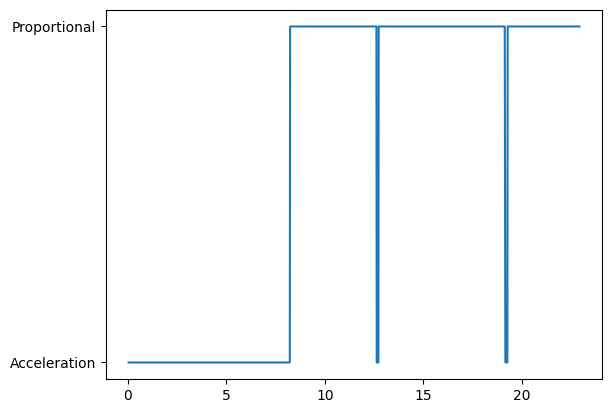

In [102]:
mtp = [p["p5.MTPMode"] for t, p in merged_player.items() if "p5.MTPMode" in p]
mtp_t = [t for t, p in merged_player.items() if "p5.MTPMode" in p]
plt.plot(mtp_t, mtp)